# Predicting heart disease using a patient’s age, maximum heart rate, ST depression, and thalassemia
## Introduction
Given our preliminary data exploration conducted with this data set, we chose to use 4 variables in order to build a classifier that will be designed to predict whether or not a patient has heart disease given these 4 variables:
* Maximum heart rate achieved by the patient (bpm)
* Age of patient
* Status of the patient's thalassemia (a blood disorder)
* ST depression (measured by ECG)
These variables were chosen as they were found to have some sort of association with our response variable (diagnosis). The question we are trying to answer with this predictive data analysis is, given the stated variables, does that person have heart disease?
## Methods
First, we load the tidyverse package to be able to perform data analysis and visualization, along with the tidymodels package which is used for classification. This data anylysis requires that the tidyverse and tidymodels R packages be downloaded.

In [1]:
library(tidyverse)
library(tidymodels)
set.seed(54321)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

Next we read in the data from the file available on the web, first by unzipping the file and then accessing only the data set we want. Although the dataset was provided as a .data file from the original source, the file contains comma-separated values, so we use read_csv. Since the data has no column names, we will rename them all using information available at [https://archive.ics.uci.edu/dataset/45/heart+disease].

In [2]:
url <- "https://archive.ics.uci.edu/static/public/45/heart+disease.zip"
heart_temp <- tempfile()
download.file(url, heart_temp)
data <- read_csv(unzip(heart_temp, "processed.cleveland.data"), col_names = FALSE, show_col_types = FALSE) |>
    rename(age = X1, sex = X2, chest_pain = X3, resting_blood_pressure = X4,
           cholesterol = X5, fasting_blood_sugar = X6,
           resting_ecg = X7, max_heart_rate = X8, exercise_angina = X9,
           st_depression = X10, slope = X11, major_vessels = X12, thal = X13,
           diagnosis = X14)
unlink(heart_temp)

Now since we don't want to use every variable in the data set, we will select only those that we selected during preliminary data analysis: age. maximum heart rate achieved, ST depression, thal, and diagnosis. Also, the authors of the data have indicated that all values 1-4 of the diagnosis variable mean a positive diagnosis, and only 0 indicates a negative diagnosis, so we will combine values 1-4 into 1 to simplify the data because our goal is only to determine the presence of heart disease.

In [3]:
data_selected <- data |>
    select(age, max_heart_rate, st_depression, thal, diagnosis) |>
    mutate(diagnosis = as_factor(diagnosis)) |>
    mutate(diagnosis = fct_recode(diagnosis, "1" = "2", "1" = "3", "1" = "4"))

cat("Table 1: Preview of the heart disease data set")
head(data_selected)

Table 1: Preview of the heart disease data set

age,max_heart_rate,st_depression,thal,diagnosis
<dbl>,<dbl>,<dbl>,<chr>,<fct>
63,150,2.3,6.0,0
67,108,1.5,3.0,1
67,129,2.6,7.0,1
37,187,3.5,3.0,0
41,172,1.4,3.0,0
56,178,0.8,3.0,0


The table above gives a sense of the data we are working with.

One issue that was found during our preliminary data analysis was that there are some rows with missing values for the `thal` variable. To be able to easily ignore these values, the below code will convert them to `NA` in R:

In [4]:
data_selected <- mutate(data_selected, thal = if_else(thal == "?", NA, thal)) |>
    mutate(thal = as.numeric(thal))

Now we can split the data set (and easily drop NA values) into a training set, which will be used to build our classifier, and a testing set, which will be used to evaluate the classifier.

In [5]:
data_split <- data_selected |>
    drop_na() |>
    mutate(diagnosis = fct_recode(diagnosis,
                                "Angiographic disease" = "1",
                                "Healthy" = "0")) |>
    initial_split(prop = 0.75, strata = diagnosis)

training_set <- training(data_split)
testing_set <- testing(data_split)

Before we begin the data analysis, a summary of the training data is presented below:

In [6]:
number_of_observations <- training_set |>
    group_by(diagnosis) |>
    summarize(count = n())

cat("Table 2: Number of patients in the data set that are healthy or have heart disease")
number_of_observations

mean_values <- training_set |>
    group_by(diagnosis) |>
    select(-thal) |>
    summarize(mean_age = mean(age), mean_max_maximum_heart_rate = mean(max_heart_rate), mean_st_depression = mean(st_depression))

cat("\n\nTable 3: Mean values of predictor variables for healthy vs. diagnosed patients")
mean_values

Table 2: Number of patients in the data set that are healthy or have heart disease

diagnosis,count
<fct>,<int>
Healthy,122
Angiographic disease,103




Table 3: Mean values of predictor variables for healthy vs. diagnosed patients

diagnosis,mean_age,mean_max_maximum_heart_rate,mean_st_depression
<fct>,<dbl>,<dbl>,<dbl>
Healthy,52.17213,157.9426,0.5204918
Angiographic disease,56.98058,140.4854,1.6533981


creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




  Figure 1: Distribution of age for patients                                  Figure 2: Distribution of maximum achieved heart rate for
            with heart disease vs. healthy                                              patients with heart disease vs. healthy

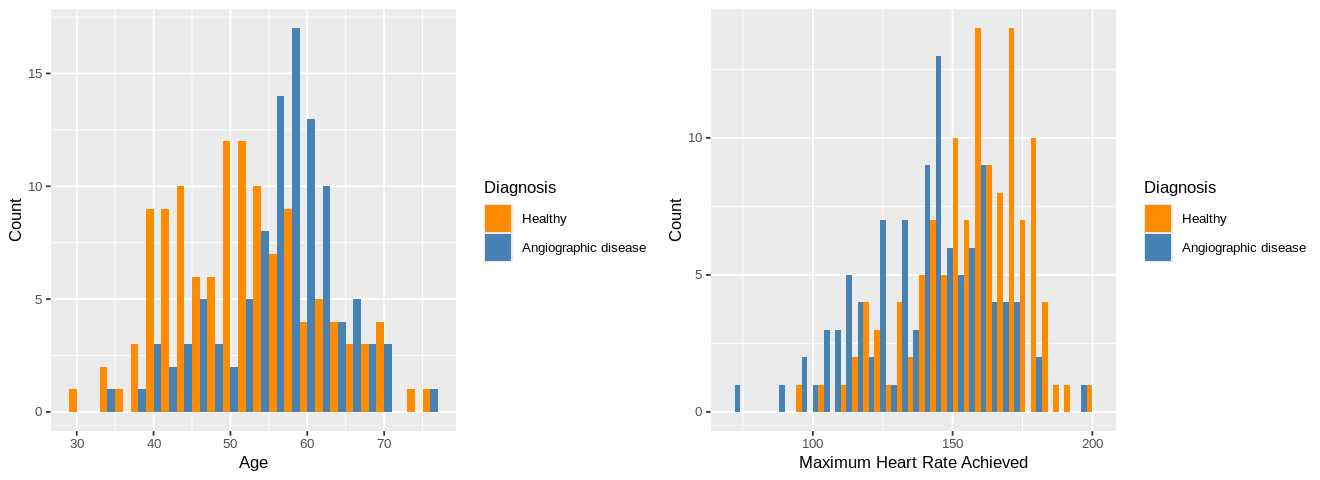

In [7]:
graph_age <- training_set |>
    ggplot(aes(x = age, fill = diagnosis)) +
    geom_histogram(position = "dodge", binwidth = 2) +
    labs(x = "Age", y = "Count", fill = "Diagnosis") +
    theme(text = element_text(size = 10)) +
    scale_fill_manual(values = c("darkorange", "steelblue"))

graph_heart_rate <- training_set |>
    ggplot(aes(x = max_heart_rate, fill = diagnosis)) +
    geom_histogram(position = "dodge", binwidth = 4) +
    labs(x = "Maximum Heart Rate Achieved", y = "Count", fill = "Diagnosis") +
    theme(text = element_text(size = 10)) +
    scale_fill_manual(values = c("darkorange", "steelblue"))

library(gridExtra)
options(repr.plot.width = 11, repr.plot.height = 4)

cat("  Figure 1: Distribution of age for patients                                  Figure 2: Distribution of maximum achieved heart rate for")
cat("\n            with heart disease vs. healthy                                              patients with heart disease vs. healthy")
grid.arrange(graph_age, graph_heart_rate, ncol = 2)

Now we will use cross-validation with 10 folds to determine the best K value to use for our K-nearest-neighbours classifier.

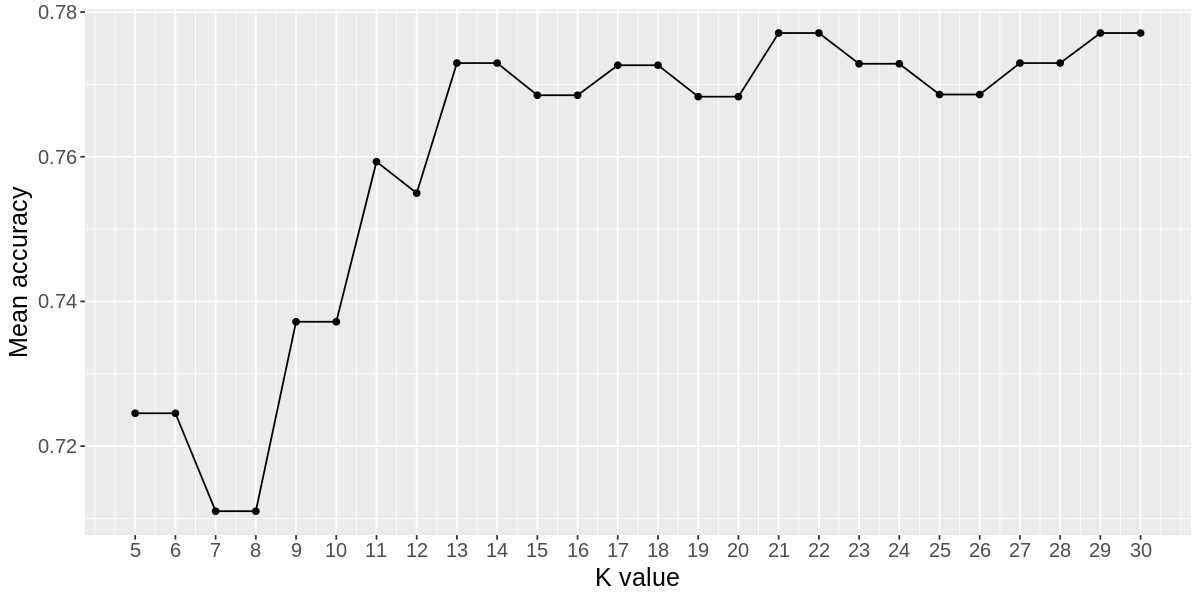

In [8]:
set.seed(54321)
knn_recipe <- recipe(diagnosis ~ ., data = training_set) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k_vals <- tibble(neighbors = 5:30)

vfold <- vfold_cv(training_set, v = 5, strata = diagnosis)

knn_fit_tuning <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec_tune) |>
    tune_grid(resamples = vfold, grid = k_vals)

tuning_metrics <- knn_fit_tuning |>
    collect_metrics()

tuning_accuracies <- filter(tuning_metrics, .metric == "accuracy")

cross_val_plot <- tuning_accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() + 
    geom_line() +
    labs(x = "K value", y = "Mean accuracy") +
    theme(text = element_text(size = 15)) +
    scale_x_continuous(breaks = 5:30)

options(repr.plot.height = 5, repr.plot.width = 10)
cross_val_plot

From the above graph, we choose K to be 30 for the rest of our classifier.

In [9]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 30) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec) |>
    fit(data = training_set)

Now we will evaluate our classifier using the testing set from the original data. To do this we first calculate the accuracy using the `metrics` function. The accuracy of a classifier represents the fraction of predictions for which the classifier makes the correct prediction, in other words, accuracy = number of correct predictions / total predictions.

We also calculate the confusion matrix, which is a convenient way of analysing the types of predictions our classifier makes.

In [13]:
predictions <- predict(knn_fit, testing_set) |>
    bind_cols(testing_set)

metrics <- predictions |>
    metrics(truth = diagnosis, estimate = .pred_class) |>
    filter(.metric == "accuracy")

accuracy <- pull(metrics, .estimate) * 100

conf_mat <- predictions |>
    conf_mat(truth = diagnosis, estimate = .pred_class)

cat("Estimated accuracy of classifier: ")
cat(accuracy)
cat(" %")

cat("\n\n")

cat("Confusion matrix for KNN classifier with K = 30")
conf_mat

Estimated accuracy of classifier: 77.63158 %

Confusion matrix for KNN classifier with K = 30

                      Truth
Prediction             Healthy Angiographic disease
  Healthy                   31                    7
  Angiographic disease      10                   28

Since we are particularly interested in classifying and identifying patients with heart disease, we set this as our "important"/"positive" class, allowing us to calculate precision and recall using the confusion matrix:

In [11]:
# when NOT using thal and K = 20:

# precision = true positives / all positive predictions
# a.k.a.
# true positives / (true positive + false positive)

precision = 24 / (24 + 13)

# recall = true positives / # of positive test data points
# a.k.a.
# true positives / (true positive + false negative)

recall = 24 / (24 + 11)

precision # 0.6486
recall # 0.6857

[1] 0.6486486

[1] 0.6857143

In [12]:
# WHEN USING THAL AND K = 30:
# precision = true positives / all positive predictions
# a.k.a.
# true positives / (true positive + false positive)

precision = 28 / (28 + 10)

# recall = true positives / # of positive test data points
# a.k.a.
# true positives / (true positive + false negative)

recall = 28 / (28 + 7)

precision # 0.7368
recall # 0.8

[1] 0.7368421

[1] 0.8